Before we train a model, we need to prepare the dataset.

First we download nearly 40MB examples of neutral and smiling faces.

In [ ]:
!curl -L -O https://github.com/hromi/SMILEsmileD/archive/master.zip
!unzip -q master.zip
!rm master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   122    0   122    0     0     31      0 --:--:--  0:00:03 --:--:--    31
100 18.4M    0 18.4M    0     0   160k      0 --:--:--  0:01:57 --:--:--     0

Then we list all the image files, and create a big list of examples as `(path, class)` tuples.

In [1]:
from utils import list_all_files
negative_paths = list(list_all_files('SMILEsmileD-master/SMILEs/negatives/negatives7/', ['.jpg']))
print 'loaded', len(negative_paths), 'negative examples'
positive_paths = list(list_all_files('SMILEsmileD-master/SMILEs/positives/positives7/', ['.jpg']))
print 'loaded', len(positive_paths), 'positive examples'
examples = [(path, 0) for path in negative_paths] + [(path, 1) for path in positive_paths]

loaded 9475 negative examples
loaded 3690 positive examples


For each path, we will load the image with `imread` and resize from 64x64 to 32x32 with `block_reduce`. This can take up to **10 seconds**.

In [2]:
import numpy as np
from skimage.measure import block_reduce
from skimage.io import imread

def examples_to_dataset(examples, block_size=2):
    X = []
    y = []
    for path, label in examples:
        img = imread(path, as_grey=True)
        img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
        X.append(img)
        y.append(label)
    return np.asarray(X), np.asarray(y)

%time X, y = examples_to_dataset(examples)

/opt/anaconda3/envs/py2version/lib/python2.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


CPU times: user 10.4 s, sys: 2.1 s, total: 12.5 s
Wall time: 16.2 s


Then we turn `X` and `y` into numpy arrays and coerce them into the right shape and range.

In [3]:
X = X.astype(np.float32) / 255.
y = y.astype(np.int32)
print X.dtype, X.min(), X.max(), X.shape
print y.dtype, y.min(), y.max(), y.shape

float32 0.0 1.0 (13165, 32, 32)
int32 0 1 (13165,)


Let's take a look at a few of the images.

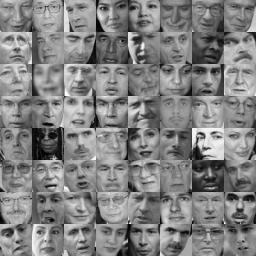

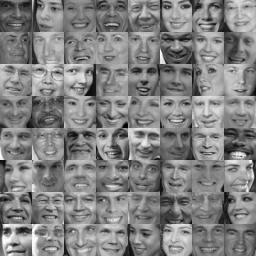

In [4]:
from utils import make_mosaic, show_array
show_array(255 * make_mosaic(X[:len(negative_paths)], 8), fmt='jpeg') # negative at the beginning
show_array(255 * make_mosaic(X[-len(positive_paths):], 8), fmt='jpeg') # positive at the end

Now we save the data to disk for so we can load it quickly when working with it later. Keras likes to use data in the (rows, cols, channels) format so we make a small change to the images before saving them.

In [5]:
X = np.expand_dims(X, axis=-1)
np.save('X.npy', X)
np.save('y.npy', y)